# 2021-10-04 RK methods for stiff problems

## Last time

* Accuracy and stability barriers
* Runge-Kutta methods

## Today

* Design of Runge-Kutta methods
* Adaptive error control
* Diagonally implicit RK
* Fully implicit RK
* Explore benchmarks

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using Zygote

default(linewidth=5)

function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")

function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

function advdiff_matrix(n; kappa=1, wind=1, upwind=0.)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.(i-1:i+1))
        diffuse = [-1, 2, -1] * kappa / dx^2
        advect_upwind = [-1, 1, 0] * wind / dx
        advect_center = [-1, 0, 1] * wind / 2dx
        stencil = -diffuse - upwind * advect_upwind - (1 - upwind) * advect_center
        append!(vals, stencil)
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

In [5]:
struct RKTable
    A::Matrix
    b::Matrix
    c::Vector
    function RKTable(A, b)
        s = size(b, 2)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk; brow=1)
    s = size(rk.b, 2)
    1 + z * rk.b[1,:]' * ((I - z*rk.A) \ ones(s))
end

heun = RKTable([0 0; 1 0], [.5 .5])
rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1 2 2 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b[1,:]
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Runge-Kutta methods

The methods we have considered thus far can all be expressed as Runge-Kutta methods, which are expressed in terms of $s$ "stage" equations (possibly coupled) and a completion formula.  For the ODE

$$ \dot u = f(t, u) $$

the Runge-Kutta method is

$$\begin{split}
Y_i = u(t) + h \sum_j a_{ij} f(t+c_j h, Y_j) \\
u(t+h) = u(t) + h \sum_j b_j f(t+c_j h, Y_j)
\end{split}$$
where $c$ is a vector of *abscissa*, $A$ is a table of coefficients, and $b$ is a vector of completion weights.

These coefficients are typically expressed in a Butcher Table
$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] . $$
We will see that, for consistency, the abscissa $c$ are always the row sums of $A$ and that $\sum_i b_i = 1$.

If the matrix $A$ is strictly lower triangular, then the method is **explicit** (does not require solving equations). 

# Measuring convergence and accuracy

In [6]:
function mms_error(h, f, u_exact; table=rk4)
    u0 = u_exact(0)
    thist, uhist = ode_rk_explicit(f, u0, tfinal=3, h=h, table=table)
    T = thist[end]
    uhist[:,end] - u_exact(T)
end

hs = .5 .^ (-3:8)
linear_oscillator_exact(t) = [cos(t), sin(t)]

linear_oscillator_exact (generic function with 1 method)

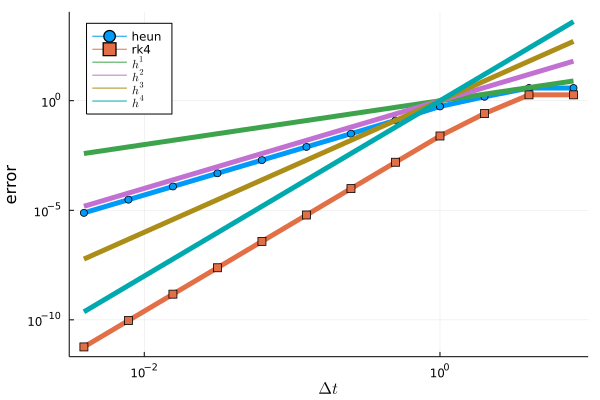

In [7]:
linear_oscillator(t, u) = [0 -1; 1 0] * u
heun_errors = mms_error.(hs, linear_oscillator, linear_oscillator_exact, table=heun)
rk4_errors = mms_error.(hs, linear_oscillator, linear_oscillator_exact, table=rk4)
plot(hs, [norm.(heun_errors) norm.(rk4_errors)], label=["heun" "rk4"], marker=:auto)
plot!(hs, [hs hs.^2 hs.^3 hs.^4], label=["\$h^$p\$" for p in [1 2 3 4]])
plot!(legend=:topleft, xscale=:log10, yscale=:log10, xlabel="\$\\Delta t\$", ylabel="error")

# Work-precision (or accuracy vs cost)


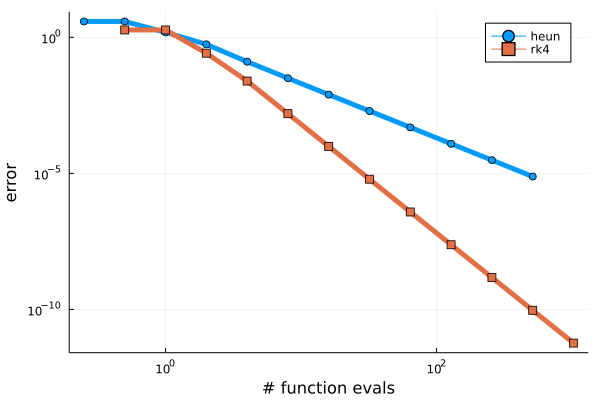

In [9]:
heun_nfeval = length(heun.c) ./ hs
rk4_nfeval = length(rk4.c) ./ hs
plot(heun_nfeval, norm.(heun_errors), marker=:auto, label="heun")
plot!(rk4_nfeval, norm.(rk4_errors), marker=:auto, label="rk4")
plot!(xscale=:log10, yscale=:log10, xlabel="# function evals", ylabel="error")

# Effective RK stability diagrams

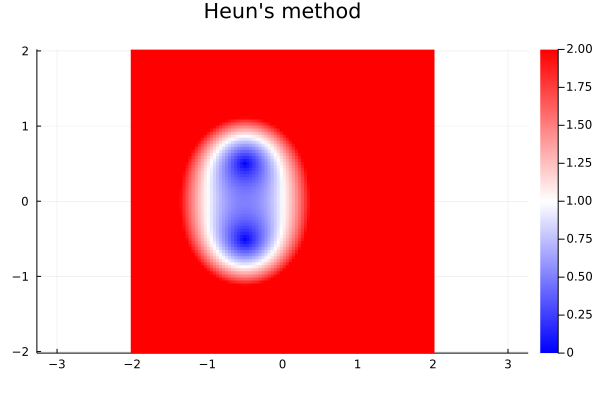

In [10]:
function rk_eff_stability(z, rk; brow=1)
    s = size(rk.b, 2)
    fsal = rk.b[1,:] ≈ rk.A[end,:]
    z = (s - fsal) * z
    1 + z * rk.b[brow,:]' * ((I - z*rk.A) \ ones(s))
end
plot_stability(z -> rk_eff_stability(z, heun), "Heun's method")

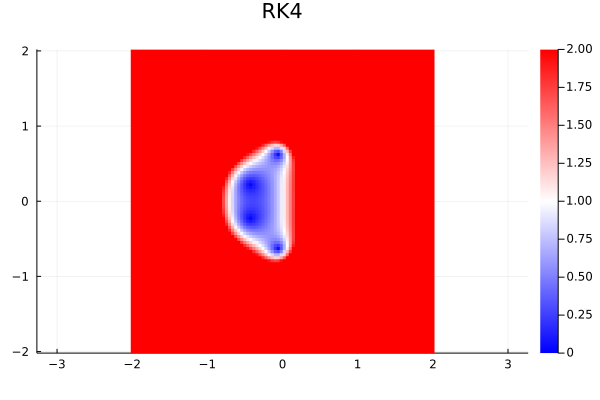

In [11]:
plot_stability(z -> rk_eff_stability(z, rk4), "RK4")

# Runge-Kutta order conditions

We consider the autonomous differential equation

$$ \dot u = f(u) . $$

Higher derivatives of the exact soultion can be computed using the chain rule, e.g.,

\begin{align*}
\ddot u(t) &= f'(u) \dot u = f'(u) f(u) \\
\dddot u(t) &= f''(u) f(u) f(u) + f'(u) f'(u) f(u) . \\
\end{align*}

Note that if $f(u)$ is linear, $f''(u) = 0$.
Meanwhile, the numerical solution is a function of the time step $h$,

$$\begin{split}
Y_i(h) &= u(0) + h \sum_j a_{ij} f(Y_j) \\
U(h) &= u(0) + h \sum_j b_j f(Y_j).
\end{split}$$

We will take the limit $h\to 0$ and equate derivatives of the numerical solution.  First we differentiate the stage equations,

\begin{split}
Y_i(0) &= u(0) \\
\dot Y_i(0) &= \sum_j a_{ij} f(Y_j) \\
\ddot Y_i(0) &= 2 \sum_j a_{ij} \dot f(Y_j) \\
&= 2 \sum_j a_{ij} f'(Y_j) \dot Y_j \\
&= 2\sum_{j,k} a_{ij} a_{jk} f'(Y_j) f(Y_k) \\
\dddot Y_i(0) &= 3 \sum_j a_{ij} \ddot f (Y_j) \\
&= 3 \sum_j a_{ij} \Big( \sum_k f''(Y_j) \dot Y_j \dot Y_k + f'(Y_j) \ddot Y_j \Big) \\
&= 3 \sum_{j,k,\ell} a_{ij} a_{jk} \Big( a_{j\ell} f''(Y_j) f(Y_k) f(Y_\ell) + 2 a_{k\ell} f'(Y_j) f'(Y_k) f(Y_\ell)  \Big)
\end{split}

where we have used Liebnitz's formula for the $m$th derivative,
$$ (h \phi(h))^{(m)}|_{h=0} = m \phi^{(m-1)}(0) .$$
Similar formulas apply for $\dot U(0)$, $\ddot U(0)$, and $\dddot U(0)$, with $b_j$ in place of $a_{ij}$.

# Order conditions are nonlinear algebraic equations

Equating terms $\dot u(0) = \dot U(0)$ yields
$$ \sum_j b_j = 1, $$
equating $\ddot u(0) = \ddot U(0)$ yields
$$ 2 \sum_{j,k} b_j a_{jk} = 1 , $$
and equating $\dddot u(0) = \dddot U(0)$ yields the two equations
\begin{split}
  3\sum_{j,k,\ell} b_j a_{jk} a_{j\ell} &= 1 \\
  6 \sum_{j,k,\ell} b_j a_{jk} a_{k\ell} &= 1 .
\end{split}

# Observations

* These are systems of nonlinear equations for the coefficients $a_{ij}$ and $b_j$.  There is no guarantee that they have solutions.
* The number of equations grows rapidly as the order increases.

|  | $u^{(1)}$       | $u^{(2)}$   |  $u^{(3)}$ | $u^{(4)}$ | $u^{(5)}$ | $u^{(6)}$ | $u^{(7)}$ | $u^{(8)}$ | $u^{(9)}$ | $u^{(10)}$ |
| ----------- |---|---|---|---|---|----|----|-----|-----|-----|
| # terms     | 1 | 1 | 2 | 4 | 9 | 20 | 48 | 115 | 286 | 719 |
| cumulative | 1 | 2 | 4 | 8 | 17 | 37 | 85 | 200 | 486 | 1205 |

* Usually the number of order conditions does not exactly match the number of free parameters, meaning that the remaining parameters can be optimized (usually numerically) for different purposes, such as to minimize the leading error terms or to maximize stability in certain regions of the complex plane.  Finding globally optimal solutions can be extremely demanding.

* Rooted trees provide a convenient notation

![Trees and elementary differentials up to order 5. From Hairer, Nørsett, and Wanner.](../img/rktrees.png)

# Theorem (from Hairer, Nørsett, and Wanner)

A Runge-Kutta method is of order $p$ if and only if
$$ \gamma(\mathcal t) \sum_{j} b_j \Phi_j(t) = 1 $$
for all trees $t$ of order $\le p$.

For a linear autonomous equation
$$ \dot u = A u $$
we only need one additional order condition per order of accuracy because $f'' = 0$.
These conditions can also be derived by equating derivatives of the stability function $R(z)$ with the exponential $e^z$.
For a linear non-autonomous equation
$$ \dot u = A(t) u + g(t) $$
or more generally, an autonomous system with quadratic right hand side,
$$ \dot u = B (u \otimes u) + A u + C $$
where $B$ is a rank 3 tensor, we have $f''' = 0$, thus limiting the number of order conditions.

# Embedded error estimation

It is often possible to design Runge-Kutta methods with multiple completion orders, say of order $p$ and $p-1$.

$$\left[ \begin{array}{c|c} c & A \\ \hline & b^T  \\ & \tilde b^T \end{array} \right] . $$

The classical RK4 does not come with an embedded method, but most subsequent RK methods do. The [Bogacki-Shampine method](https://en.wikipedia.org/wiki/Bogacki%E2%80%93Shampine_method) is one such method.

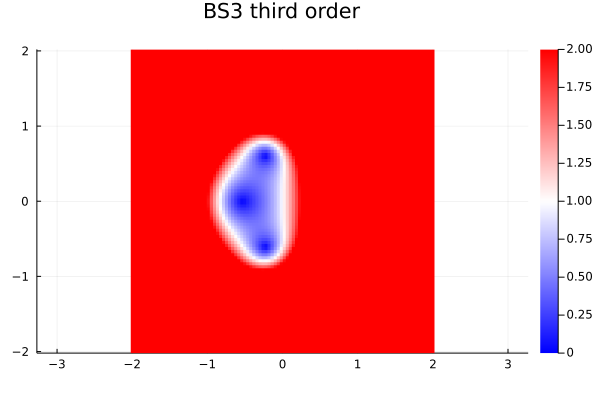

In [12]:
bs3 = RKTable([0 0 0 0; 1/2 0 0 0; 0 3/4 0 0; 2/9 1/3 4/9 0],
    [2/9 1/3 4/9 0; 7/24 1/4 1/3 1/8])
plot_stability(z -> rk_eff_stability(z, bs3), "BS3 third order")

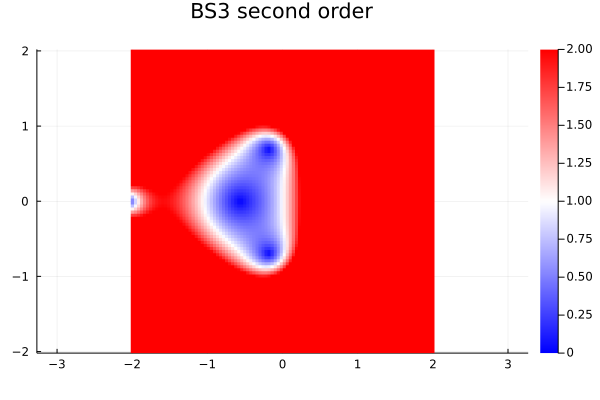

In [13]:
plot_stability(z -> rk_eff_stability(z, bs3, brow=2), "BS3 second order")

# Properties

In [14]:
display(bs3.A)
display(bs3.b)

4×4 Matrix{Float64}:
 0.0       0.0       0.0       0.0
 0.5       0.0       0.0       0.0
 0.0       0.75      0.0       0.0
 0.222222  0.333333  0.444444  0.0

2×4 Matrix{Float64}:
 0.222222  0.333333  0.444444  0.0
 0.291667  0.25      0.333333  0.125

* First same as last (FSAL): the completion formula $b$ is the same as the last row of $A$.
  * Stage can be reused as first stage of the next time step. So this 4-stage method has a cost equal to a 3-stage method.
* [Fehlberg](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method), a 6-stage, 5th order method for which the 4th order embedded formula has been optimized for accuracy.
* [Dormand-Prince](https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method), a 7-stage, 5th order method with the FSAL property, with the 5th order completion formula optimized for accuracy.

# Stability regions

![](../img/rkstability-fehlberg.png)

![](../img/rkstability-dp.png)

# Adaptive step size control

Given a completion formula $b^T$ of order $p$ and $\tilde b^T$ of order $p-1$, an estimate of the local truncation error (on this step) is given by
$$ e_{\text{loc}}(h) = \lVert h (b - \tilde b)^T f(Y) \rVert \in O(h^p) . $$
Given a tolerance $\epsilon$, we would like to find $h_*$ such that
$$ e_{\text{loc}}(h_*) < \epsilon . $$
If $$e_{\text{loc}}(h) = c h^p$$ for some constant $c$, then
$$ c h_*^p < \epsilon $$
implies
$$ h_* < \left( \frac{\epsilon}{c} \right)^{1/p} . $$
Given the estimate with the current $h$,
$$ c = e_{\text{loc}}(h) / h^p $$
we conclude
$$ \frac{h_*}{h} < \left( \frac{\epsilon}{e_{\text{loc}}(h)} \right)^{1/p} . $$

## Notes
* Usually a "safety factor" less than 1 is included so the predicted error is less than the threshold to reject a time step.
* We have used an absolute tolerance above.  If the values of solution variables vary greatly in time, a relative tolerance $e_{\text{loc}}(h) / \lVert u(t) \rVert$ or a combination thereof is desirable.
* There is a debate about whether one should optimize the rate at which error is accumulated with respect to work (estimate above) or with respect to simulated time (as above, but with error behaving as $O(h^{p-1})$).  For problems with a range of time scales at different periods, this is usually done with respect to work.
* Global error control is an active research area.

# Diagonally Implicit Runge-Kutta methods

<div class="floatright">

$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & 0 \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] $$
</div>

In [17]:
# From Hairer and Wanner Table 6.5 L-stable SDIRK
dirk4 = RKTable([1/4 0 0 0 0; 1/2 1/4 0 0 0; 17/50 -1/25 1/4 0 0; 371/1360 -137/2720 15/544 1/4 0; 25/24 -49/48 125/16 -85/12 1/4],
    [24/24 -49/48 125/16 -85/12 1/4; 59/48 -17/96 225/32 -85/12 0]);
#dirk4.A

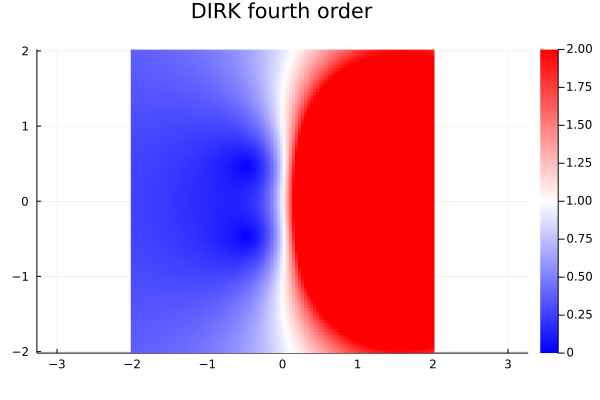

In [18]:
plot_stability(z -> rk_eff_stability(z, dirk4, brow=1), "DIRK fourth order")

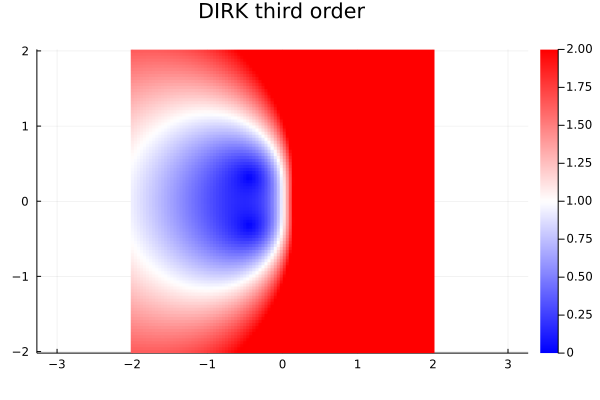

In [19]:
plot_stability(z -> rk_eff_stability(z, dirk4, brow=2), "DIRK third order")

# Fully implicit Runge-Kutta methods

<div class="floatright">

$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] $$
</div>

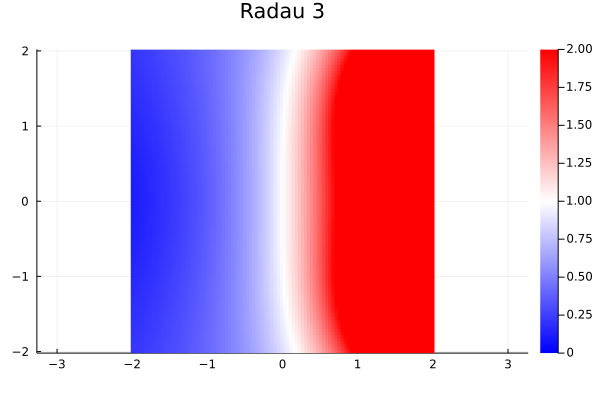

In [20]:
radau3 = RKTable([5/12 -1/12; 3/4 1/4], [3/4 1/4])
plot_stability(z -> rk_eff_stability(z, radau3), "Radau 3")

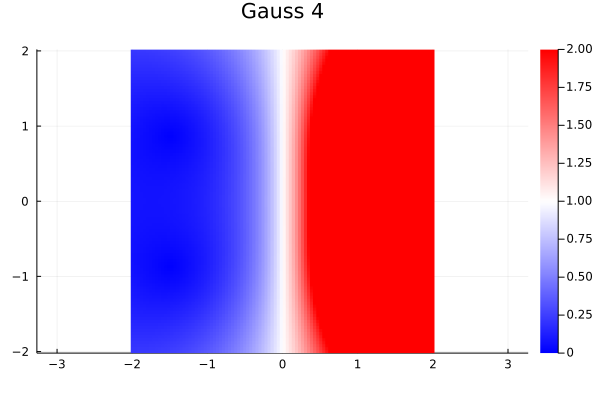

In [21]:
gauss4 = RKTable([1/4 1/4-sqrt(3)/6; 1/4+sqrt(3)/6 1/4],
    [1/2 1/2])
plot_stability(z -> rk_eff_stability(z, gauss4), "Gauss 4")

# Explore benchmarks: https://benchmarks.sciml.ai/

## Today
* Work in groups of 2 or 3
* Find one interesting figure

### Report-out/discuss
* Explain something about the figure
* Ask a question

## For next time (still in groups)
* Pick any two methods
* Make a hypothesis about how they'll work on advection-diffusion
* Test your hypothesis and share a figure on Zulip